In this additional notebook, we want to share to progress we've made on creating Live sentiment analysis.
Sadly, we couldn't complete the live analysis and visualization workflow. But we still think it's interesting to show the code on the API stream, as it was quite an long process to get that working.

Our idea was to have a lie API running, and do a live visualization and analization of tweet sentiments per city. This would look like a dashboard containing live information on sentiments on corona per city. We would integrate this script with the other scripts as following: 

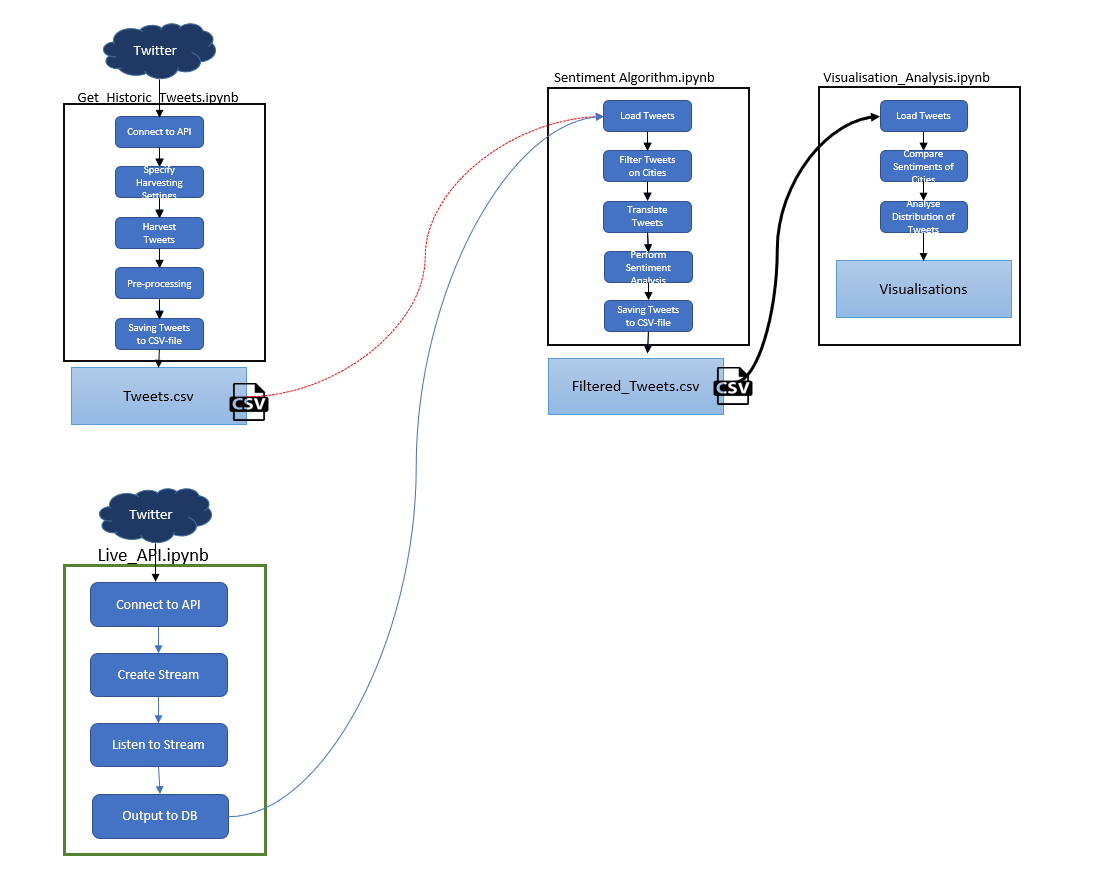

The static get_historic_API  file will be replaced by the dynamic Live_API file. We will no longer use the flow indicated by the red arrow. 
We would continuously have to read data from the database instead of reading in a csv file. 
The two API's (live and historic) work differently, and it was quite hard to figure out the differences in querying. We we were finally able to output the tweets into the exact sam format as the historic tweets. 


In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import json
import tweepy
import os

import re
import emoji

import csv
import time

from tweepy.streaming import StreamListener
from datafreeze import freeze

# Code from tutorial: https://www.dataquest.io/blog/streaming-data-python/
import dataset #https://dataset.readthedocs.io/en/latest/api.html
from sqlalchemy.exc import ProgrammingError

In [2]:
# Setup connection with the API 

# Key
Key1 = ""

# Secret Key
Key2 = "" 

# Access token
ACCESS_TOKEN = ""

# Access token secret
ACCESS_TOKEN_SECRET = ""



In [3]:
# Set up and test API

# Authorize 
auth = tweepy.OAuthHandler(Key1, Key2)

# Authorize with access token 
auth.set_access_token(ACCESS_TOKEN,ACCESS_TOKEN_SECRET)

api = tweepy.API(auth, wait_on_rate_limit=True,
          wait_on_rate_limit_notify=True)

# Test authorization

try:
    api.verify_credentials()
    print("Authentication OK")
except:
    print("Error during authentication")

Authentication OK


In [4]:
TRACK_TERMS = ["covid", "corona", "vaccineren", "vaccin", "gevaccineerd ", "rivm", "persco", "persconferentie", 
               "sneltest", "quarantaine", "lockdown", "mondkapje", "testafspraak ", "testcapaciteit", 
               "risicogroep","pandemie"]
CONNECTION_STRING = "sqlite:///tweets.db"
CSV_NAME = "tweets.csv"
TABLE_NAME = "tweets"

db = dataset.connect(CONNECTION_STRING)


In [5]:
def clean_text(text):
    if text is None:
        return("")
    '''clean text of links, special characters, @mentions, 
    double spaces, lowercase everthing'''
    cleaned = re.sub(r"(?:\@|https?\://)\S+", "", text)
    cleaned = ' '.join(cleaned.split())
    cleaned = cleaned.lower()
    return(cleaned)


class StreamListener2(StreamListener):
    '''class for handling incoming statusses'''
    
    def on_status(self, status):
        '''put incoming statusses in DB in correct format'''
        if hasattr(status, "retweeted_status"):
            return
        
        description = status.user.description
        loc = status.user.location
        
        coords = status.coordinates
        geo = status.geo
        name = status.user.screen_name
        user_created = status.user.created_at
        followers = status.user.followers_count
        id_str = status.id_str
        created = status.created_at
        retweets = status.retweet_count
        bg_color = status.user.profile_background_color
        text = ""
        
        if geo is not None:
            geo = json.dumps(geo)

        if coords is not None:
            coords = json.dumps(coords)
            
        if hasattr(status, "extended_tweet"):
            text = status.extended_tweet["full_text"]  
        else:
            text = status.text
                
        table = db[TABLE_NAME]
        
        text = clean_text(text)
        loc = clean_text(loc)
        
        try:
            table.insert(dict(
                user_description=description,
                user_location=loc,
                coordinates=coords,
                text=text,
                geo=geo,
                user_name=name,
                user_created=user_created,
                user_followers=followers,
                id_str=id_str,
                created=created,
                retweet_count=retweets,
                user_bg_color=bg_color,

            ))
        except ProgrammingError as err:
            print(err)

    def on_error(self, status_code):
        if status_code == 420:
            #returning False in on_data disconnects the stream
            print("errrrr")
            return False

In [6]:
# Start listening to the stream
# Tweepy is able to do this asynchronized, so that we can continue to use the notebook
# while continuously listening to the stream (and adding the statusses to the DB)

stream_listener = StreamListener2()
stream = tweepy.Stream(auth=api.auth, listener=stream_listener)
stream.filter(track=TRACK_TERMS, languages=["nl"], is_async=True)

In [9]:
# We're able to check the incoming tweets while running the script
# at the time of running, we harvested 4 tweets that are visible below
# refreshing this cell shows the current data in the database 

db = dataset.connect(CONNECTION_STRING)
result = db[TABLE_NAME].all()
freeze(result, format='csv', filename=CSV_NAME)

data = pd.read_csv("tweets.csv")
pd.set_option('display.max_colwidth', None)
len(data)


4

In [10]:
data

,id,user_description,user_location,coordinates,text,geo,user_name,user_created,user_followers,id_str,created,retweet_count,user_bg_color
0,1,"Bijna afgestudeerd bioloog, zelfstandig fotografe, voorzitter Landelijk Overleg Biologiestudenten, feministe en ik praat graag over zelfliefde en seksualiteit","amsterdam, nederland",NaN,"die makker van de sgp die zegt dat mannen biologisch sterker zijn. pers jij dan even lekker een baby uit he, oh en wie worden er ook al weer ouder en volgens mij liggen er meer mannen op de ic met covid 🤬🤬🤬🤬",NaN,ishara_merhai,2011-10-19T17:06:33,107,1384899595801710595,2021-04-21T15:59:28,0,000000
1,2,Hobby's: sporten en hardlopen.,"'s-hertogenbosch, noord-braban",NaN,22 op dag 12!,NaN,KB_NL_073,2015-01-30T21:25:13,282,1384899598892867590,2021-04-21T15:59:29,0,C0DEED
2,3,Twitter voor serieuze!?/belangrijke!? berichten!?/vragen!? naar/aan leden van de tweede en eerste kamer.,NaN,NaN,nog even ter info waar de burger denkt #kromtoch m.b.t. vaccinaties etc.,NaN,Erick63634273,2020-10-28T14:40:07,2,1384899613577072641,2021-04-21T15:59:32,0,F5F8FA
3,4,"Ik ben geïnteresseerd in troep en trollen.\nIk bedoel, recyclen en Noordse mythologie.",NaN,NaN,prikken ja of nee? alle voors en tegens van corona-vaccinatie…,NaN,BasKlootwijk1,2020-11-10T23:49:52,78,1384899614105538563,2021-04-21T15:59:32,0,F5F8FA
